## Import dependencies

In [1]:
import sys
import pathlib
current_path = pathlib.Path().absolute()
root_path = "{0}/..".format(current_path)
sys.path.append("{0}/src".format(root_path))

import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from utils import Config, ImageUtil, create_model

In [2]:
seed_value = 33
os.environ["PYTHONHASHSEED"] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

## Prepare configuration (training and test)

In [3]:
image_util = ImageUtil()
config_path = "{0}/config/segmentation_wood_plate.json".format(root_path)
config = Config(config_path)

# Select the predefined model
config.model = "vanilla_unet"

# Set training configuration
config.train.files_path = "{0}/img/wood_plate/train".format(root_path)
config.train.mask_files_path = "{0}/masks".format(config.train.files_path)
config.train.checkpoints_path = "{0}/checkpoints/wood_plate".format(root_path)
config.train.learning_rate = 1e-5
config.train.batch_size = 10
config.train.epochs = 50

# Set eval configuration (will be used for prediction)
config.eval.files_path = "{0}/img/wood_plate/eval".format(root_path)
config.eval.threshold = 0.1

# We only have few images, so we will create some new augmented
config.train.image_data_generator.loop_count = 10

## Create model

In [4]:
model_container = create_model(config)

## Train model

In [5]:
model_container.train()

Train on 192 samples, validate on 48 samples
Epoch 1/50
192/192 [==============================] - 10s 51ms/sample - loss: 0.1137 - accuracy: 0.9838 - val_loss: 0.0711 - val_accuracy: 0.9911
Epoch 2/50
192/192 [==============================] - 3s 17ms/sample - loss: 0.0798 - accuracy: 0.9910 - val_loss: 0.0580 - val_accuracy: 0.9913
Epoch 3/50
192/192 [==============================] - 3s 17ms/sample - loss: 0.0636 - accuracy: 0.9922 - val_loss: 0.0512 - val_accuracy: 0.9913
Epoch 4/50
192/192 [==============================] - 3s 17ms/sample - loss: 0.0545 - accuracy: 0.9925 - val_loss: 0.0477 - val_accuracy: 0.9913
Epoch 5/50
192/192 [==============================] - 3s 17ms/sample - loss: 0.0490 - accuracy: 0.9927 - val_loss: 0.0456 - val_accuracy: 0.9913
Epoch 6/50
192/192 [==============================] - 3s 17ms/sample - loss: 0.0455 - accuracy: 0.9927 - val_loss: 0.0444 - val_accuracy: 0.9913
Epoch 7/50
192/192 [==============================] - 3s 17ms/sample - loss: 0.0434 

## Show history

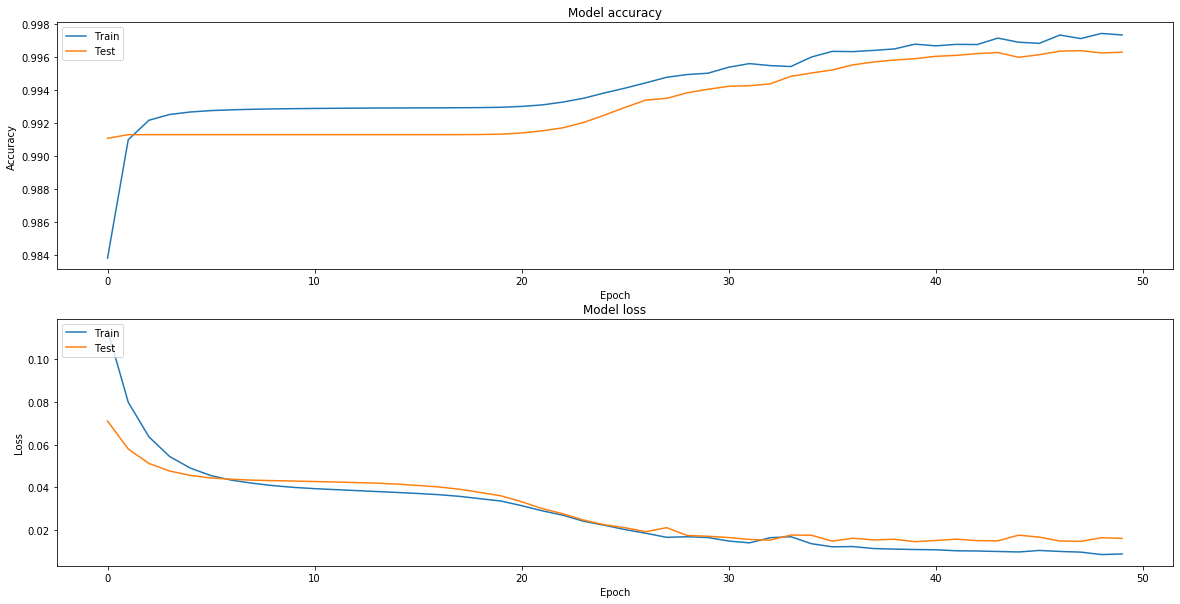

In [6]:
history = model_container.history
plt.figure(figsize=(20, 10))
plt.subplot(211)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.subplot(212)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

## Prepare test images

In [7]:
color_mode = image_util.cv2_grayscale
if config.input_shape[2] == 3:
    color_mode = image_util.cv2_color
test_images = image_util.load_images(config.eval.files_path, color_mode)
tmp_imgs = []
for img in test_images:
    res = image_util.resize_image(img, config.input_shape[1], config.input_shape[0])
    norm = image_util.normalize(res, config.input_shape)
    tmp_imgs.append(norm)
test_images = np.array(tmp_imgs, dtype=np.float32)

## Predict

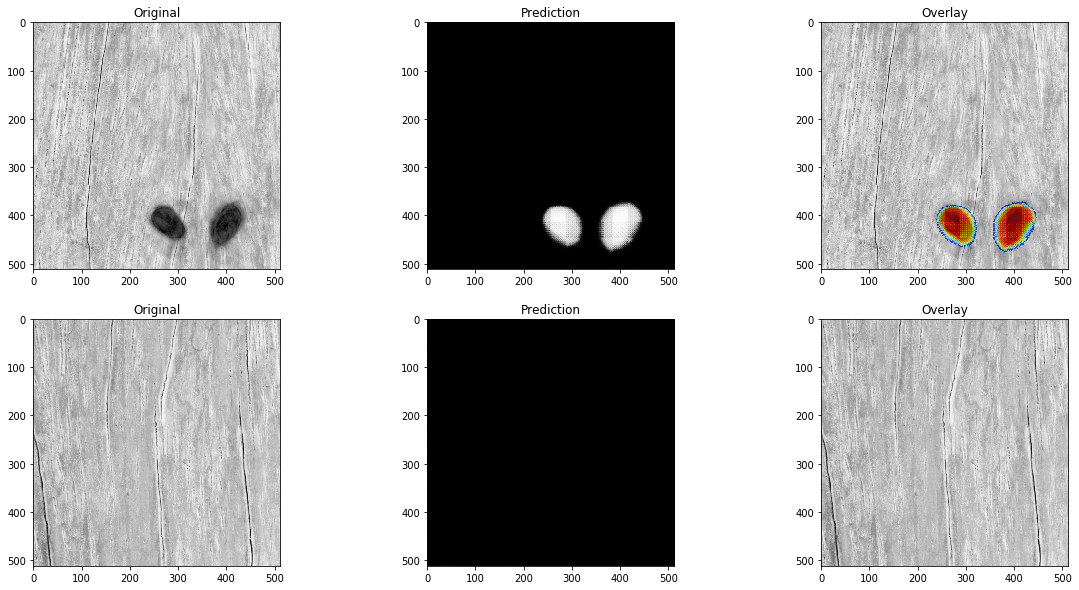

In [8]:
model_container.predict(test_images)
model_container.plot_predictions(test_images)